In [4]:
from utils.dataset import CTCdataset
ds = CTCdataset('train')
ds[0]['data'].shape

zero_counter = 0
pixel_counter = 0
for sample in ds:
    data = sample['data']
    data = data.sum(axis = -1)
    num_zeros = (data == 0).sum()
    zero_counter += num_zeros

    num_pixels = data.size
    pixel_counter += num_pixels
print(f'Number of zeros: {zero_counter}')
print(f'Number of pixels: {pixel_counter}')
print(f'Percentage of zeros: {zero_counter/pixel_counter*100:.2f}%')

Number of zeros: 0
Number of pixels: 134809335
Percentage of zeros: 0.00%


In [22]:
import random
from tqdm import tqdm
import numpy as np
from scipy.interpolate import interp1d
from pathlib import Path
import pandas as pd
from scipy.io import loadmat
import datetime
import matplotlib.pyplot as plt
def get_all_data_paths(data_dir):
    all_dataset = {}
    all_data_paths = list(data_dir.rglob("*.mat"))
    for data_path in all_data_paths:
        label = data_path.parent.name
        if label not in all_dataset:
            all_dataset[label] = []
        all_dataset[label].append(data_path)
    return all_dataset
def split_data(all_dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    if train_ratio + val_ratio + test_ratio != 1:
        raise ValueError("Sum of ratios must be equal to 1")

    # Initialize dictionaries for train, val, and test sets
    train_set = {}
    val_set = {}
    test_set = {}

    for label, paths in all_dataset.items():
        # Shuffle paths to ensure randomness
        random.shuffle(paths)
        
        # Calculate split indices
        n_total = len(paths)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        # Create splits
        train_paths = paths[:n_train]
        val_paths = paths[n_train:n_train + n_val]
        test_paths = paths[n_train + n_val:]

        # Store paths by label in the respective dictionaries
        train_set[label] = train_paths
        val_set[label] = val_paths
        test_set[label] = test_paths

    return train_set, val_set, test_set

data_dir = Path('data/polygon_data')

all_dataset = get_all_data_paths(data_dir)

train_set, val_set, test_set = split_data(all_dataset)

splited_dataset = {'train': train_set, 'val': val_set, 'test': test_set}
scl = []
band_data_accumulated = {}
class_counter = {}
for mode, dataset in splited_dataset.items():
    print(f"{mode} set:")
    for label, paths in dataset.items():
        for path in paths:
            data = loadmat(path)
            data_arrays = [data[key] for key in data.keys() if key not in ['__header__', '__version__', '__globals__']]
            stacked_data = np.stack(data_arrays, axis=-1) # shape: (n_pixels, n_bands, n_dates)
            stacked_data = np.transpose(stacked_data, (0,2,1)) # shape: (n_pixels, n_dates, n_bands)
            # Calculate and print the data range for each band
           # Calculate the data range for each band
            n_bands = stacked_data.shape[2]
            for band in range(n_bands):
                band_data = stacked_data[:, :, band].flatten()
                band_min = np.min(band_data)
                band_max = np.max(band_data)
                
                if band not in band_data_accumulated:
                    band_data_accumulated[band] = band_data
                else:
                    band_data_accumulated[band] = np.concatenate((band_data_accumulated[band], band_data))

            
# Plot the distribution of each band
for band in sorted(band_data_accumulated.keys()):
    plt.figure()
    plt.hist(band_data_accumulated[band], bins=50, alpha=0.75)
    plt.title(f'Distribution of Band {band}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

train set:
val set:
test set:


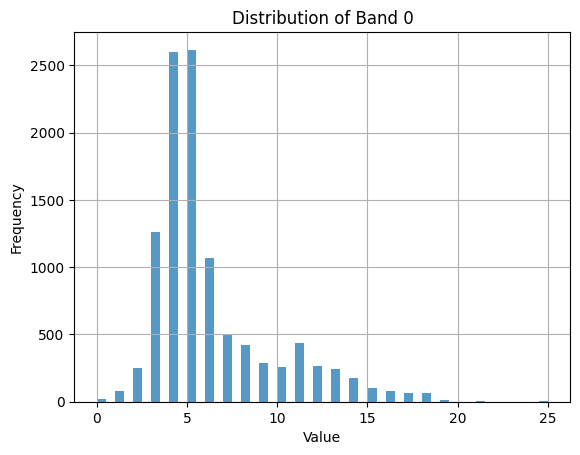

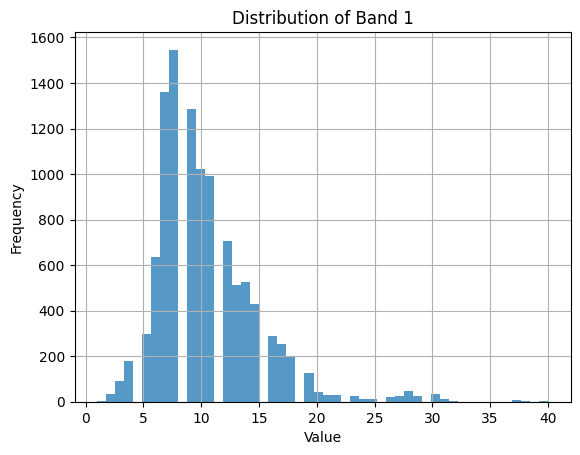

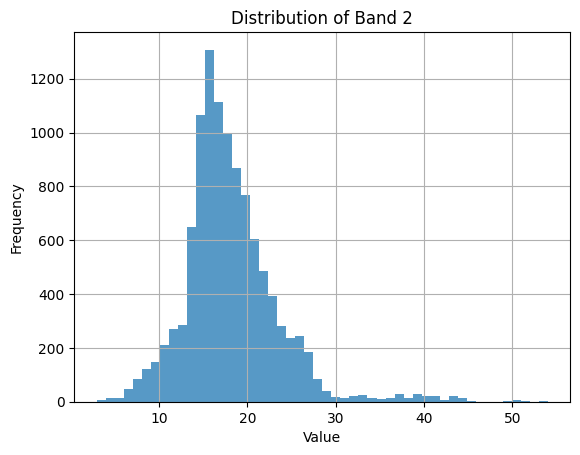

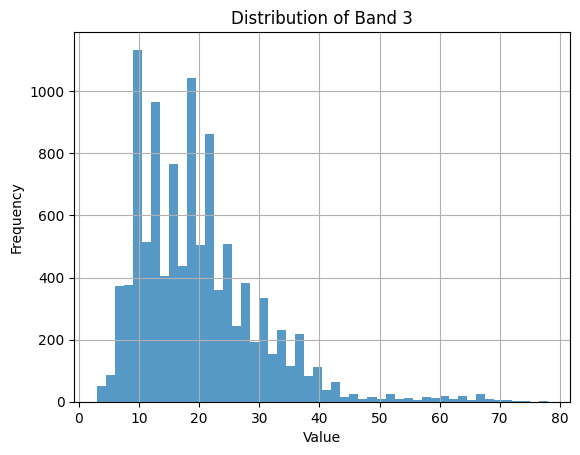

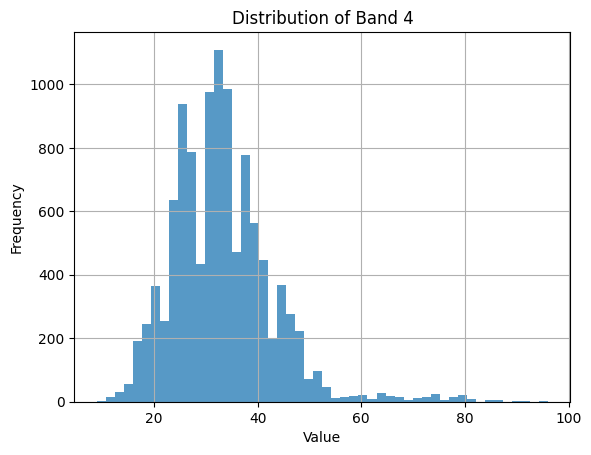

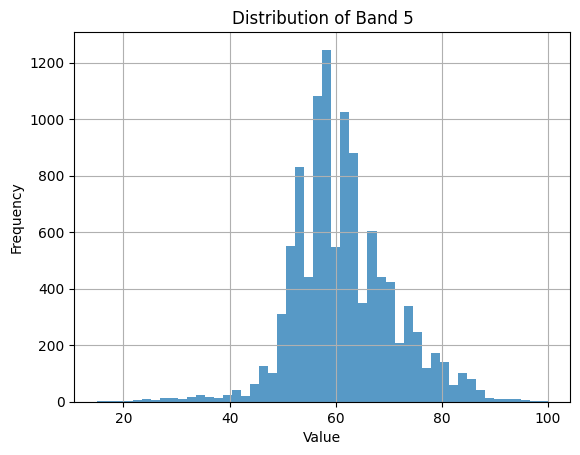

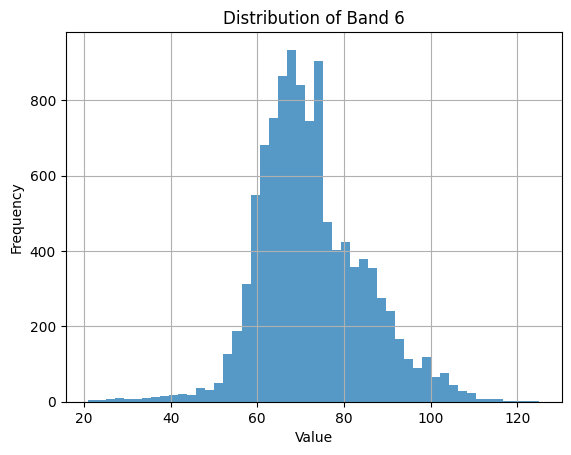

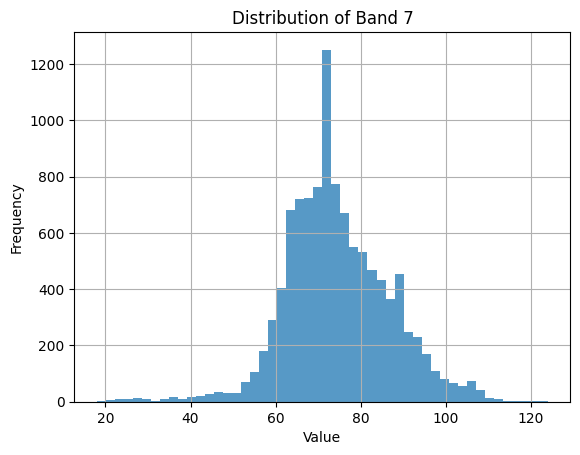

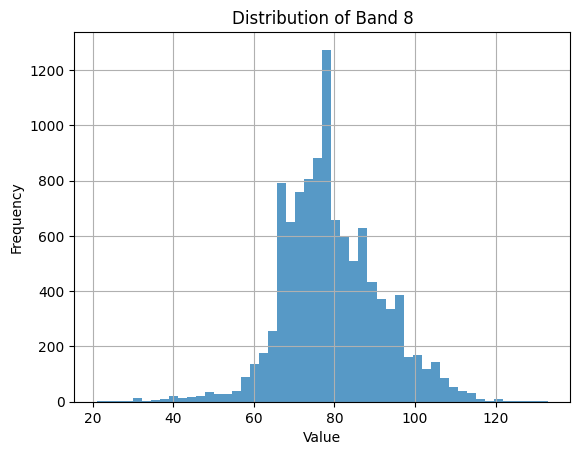

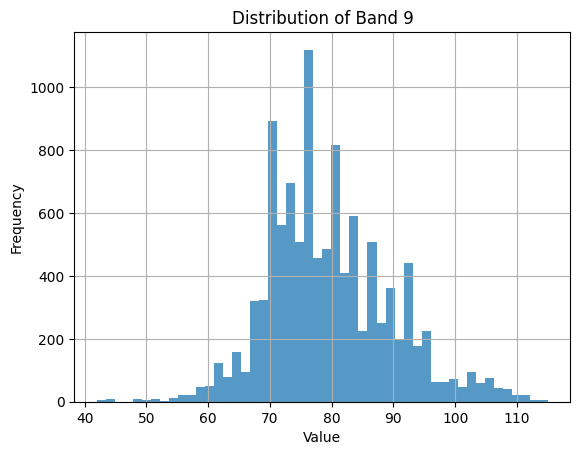

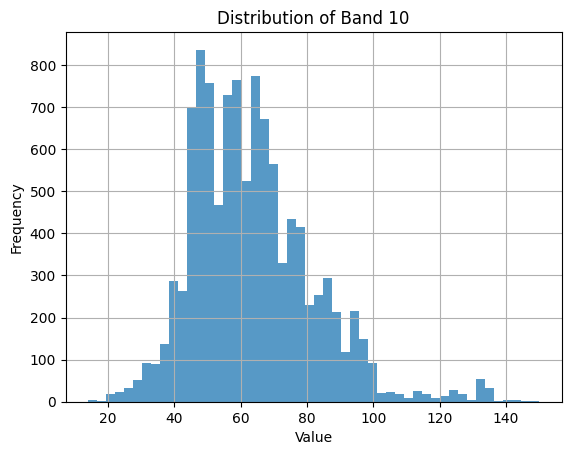

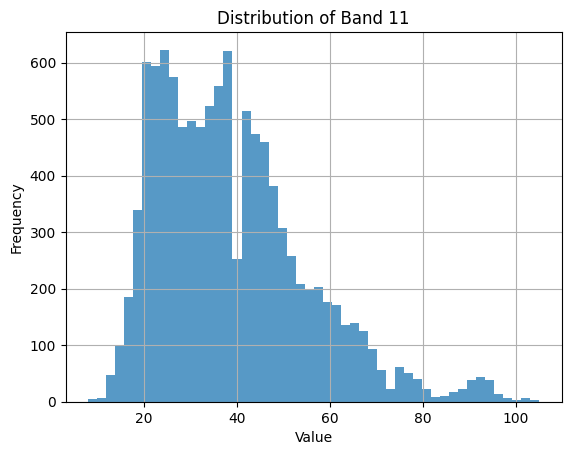

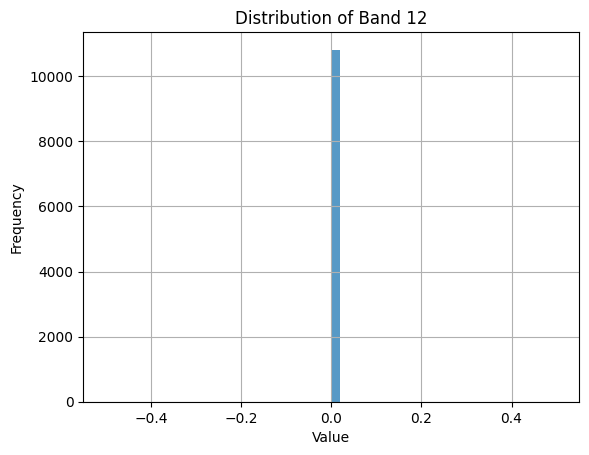

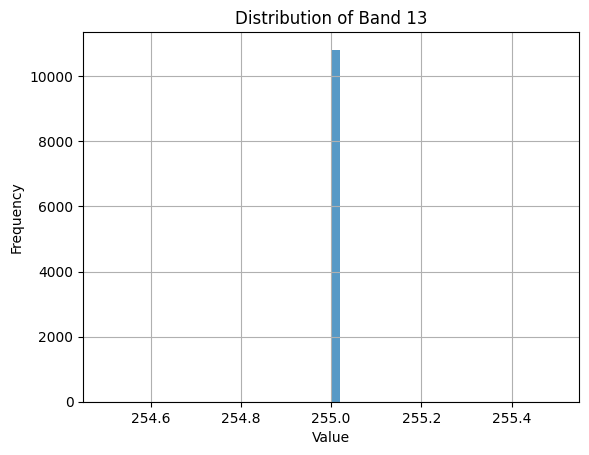

In [32]:
import numpy as np
from scipy.io import loadmat

class_counter = {}
ctc_counter = {'CTC': 0, 'Others': 0}

for mode, dataset in splited_dataset.items():
    for label, paths in dataset.items():
        if label not in class_counter:
            class_counter[label] = {'samples': 0, 'pixels': 0}
        
        for path in paths:
            data = loadmat(path)
            data_arrays = [data[key] for key in data.keys() if key not in ['__header__', '__version__', '__globals__']]
            stacked_data = np.stack(data_arrays, axis=-1)  # shape: (n_pixels, n_bands, n_dates)
            stacked_data = np.transpose(stacked_data, (0, 2, 1))  # shape: (n_pixels, n_dates, n_bands)
            
            # Update sample count
            class_counter[label]['samples'] += 1
            
            # Update pixel count
            n_pixels = stacked_data.shape[0]
            class_counter[label]['pixels'] += n_pixels
            
            # Update CTC and Others count
            if 'CTC' in label :
                ctc_counter['CTC'] += 1
            else:
                ctc_counter['Others'] += 1

total_samples = sum(counts['samples'] for counts in class_counter.values())
total_pixels = sum(counts['pixels'] for counts in class_counter.values())

# Print the counts and percentages for each class with alignment
print(f"{'Class':<15} {'Samples':<10} {'Pixels':<10} {'% Samples':<10} {'% Pixels':<10}")
print("-" * 60)
for label, counts in class_counter.items():
    sample_percentage = (counts['samples'] / total_samples) * 100
    pixel_percentage = (counts['pixels'] / total_pixels) * 100
    print(f"{label:<15} {counts['samples']:<10} {counts['pixels']:<10} {sample_percentage:<10.2f} {pixel_percentage:<10.2f}")

# Calculate total samples for CTC and Others
total_ctc_samples = sum(ctc_counter.values())

# Print the counts and percentages for CTC and Others
print("\nCTC and Others count:")
print(f"{'Label':<15} {'Samples':<10} {'% Samples':<10}")
print("-" * 35)
for label, count in ctc_counter.items():
    sample_percentage = (count / total_ctc_samples) * 100
    print(f"{label:<15} {count:<10} {sample_percentage:<10.2f}")

Class           Samples    Pixels     % Samples  % Pixels  
------------------------------------------------------------
RB966928        5862       1367999    12.51      12.16     
CTC20           1223       218665     2.61       1.94      
RB975242        2003       514723     4.27       4.57      
RB867515        1743       414065     3.72       3.68      
CTC9003         4777       1325027    10.19      11.77     
RB985476        1310       320185     2.80       2.85      
CTC9001         4354       1046567    9.29       9.30      
RB975201        1401       361351     2.99       3.21      
CTC9002         3128       866747     6.67       7.70      
RB975033        1166       347744     2.49       3.09      
CTC4            15669      3427900    33.44      30.46     
CTC2994         1291       368583     2.75       3.28      
CTC9005HP       1145       230470     2.44       2.05      
CV7870          1791       443206     3.82       3.94      

CTC and Others count:
Label           